<a href="https://colab.research.google.com/github/Sunitendra-Srivastava/Spam-Mail-Detection/blob/main/Email-Spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
import numpy as np
import pandas as pd
import re
import string
# Text processing and analysis
from textblob import TextBlob
from nltk.corpus import stopwords
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI ML Training/spam.csv')
df.sample(10)

,Category,Message
4421,ham,Ok i msg u b4 i leave my house.
2168,ham,Yes.he have good crickiting mind
266,ham,Same. Wana plan a trip sometme then
3469,ham,yay! finally lol. i missed our cinema trip las...
3990,ham,Ok lor. Anyway i thk we cant get tickets now c...
1220,ham,True. It is passable. And if you get a high sc...
657,ham,Sun cant come to earth but send luv as rays. c...
691,ham,Was the farm open?
1752,ham,* Was thinking about chuckin ur red green n bl...
5062,ham,"Sorry, I'll call you later. I am in meeting sir."


In [ ]:
df.head()


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.isnull().sum()


,0
Category,0
Message,0


In [ ]:
df.duplicated().sum()


415

In [ ]:
df = df.drop_duplicates()


<ipython-input-9-a3a29b8a40f6>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=df, palette="viridis")


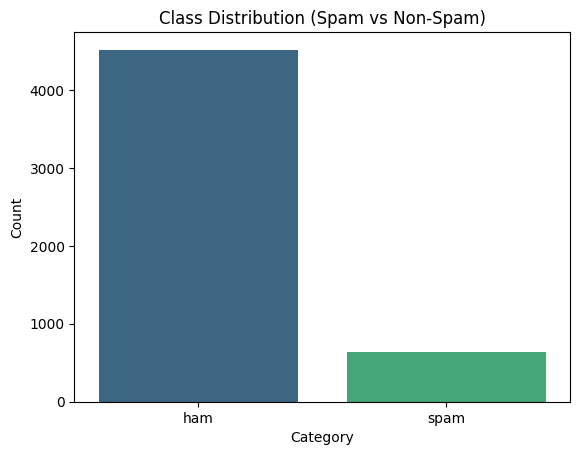

In [ ]:
sns.countplot(x='Category', data=df, palette="viridis")
plt.title("Class Distribution (Spam vs Non-Spam)")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

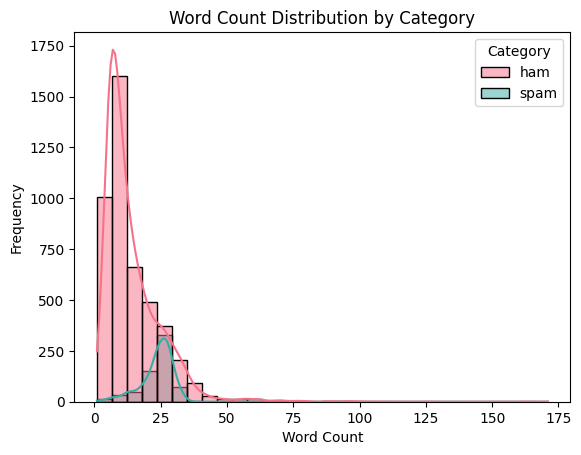

In [ ]:
df['word_count'] = df['Message'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='Category', bins=30, kde=True, palette="husl")
plt.title("Word Count Distribution by Category")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

<ipython-input-11-401a72f35d36>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='char_count', data=df, palette="coolwarm")


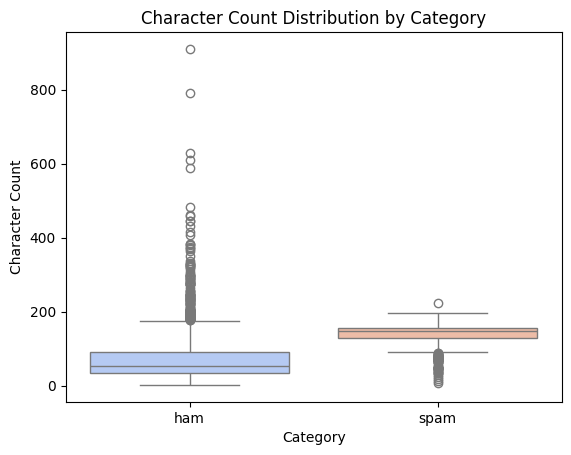

In [ ]:
df['char_count'] = df['Message'].apply(len)
sns.boxplot(x='Category', y='char_count', data=df, palette="coolwarm")
plt.title("Character Count Distribution by Category")
plt.xlabel("Category")
plt.ylabel("Character Count")
plt.show()

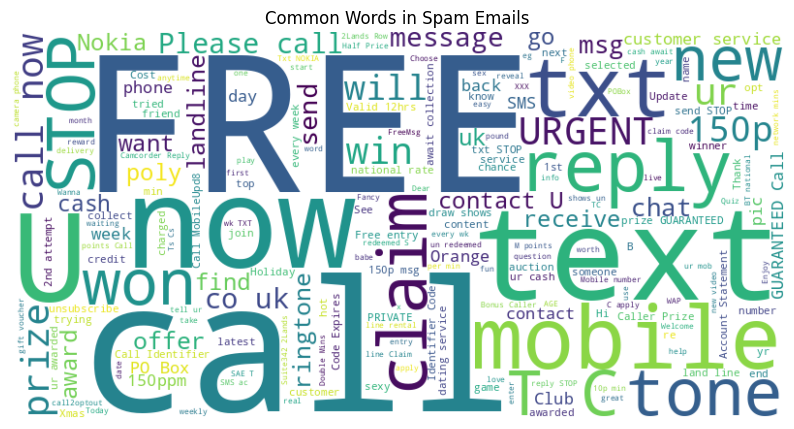

In [ ]:
spam_text = df[df['Category'] == 'spam']['Message'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Emails")
plt.show()

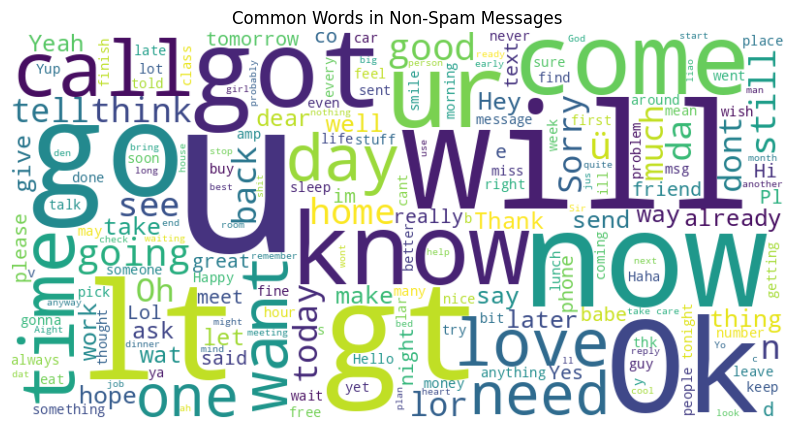

In [ ]:
non_spam_text = " ".join(df[df['Category'] == 'ham']['Message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Non-Spam Messages")
plt.show()

<ipython-input-14-faa29ee709e8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='punctuation_count', data=df, palette="Set2")


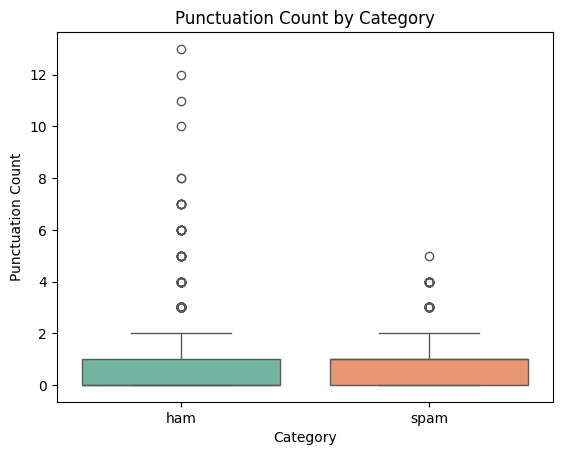

In [ ]:
df['punctuation_count'] = df['Message'].apply(lambda x: sum([1 for char in x if char in '!?']))
sns.boxplot(x='Category', y='punctuation_count', data=df, palette="Set2")
plt.title("Punctuation Count by Category")
plt.xlabel("Category")
plt.ylabel("Punctuation Count")
plt.show()

<ipython-input-15-c66728487f62>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='sentiment_polarity', data=df, palette="cubehelix")


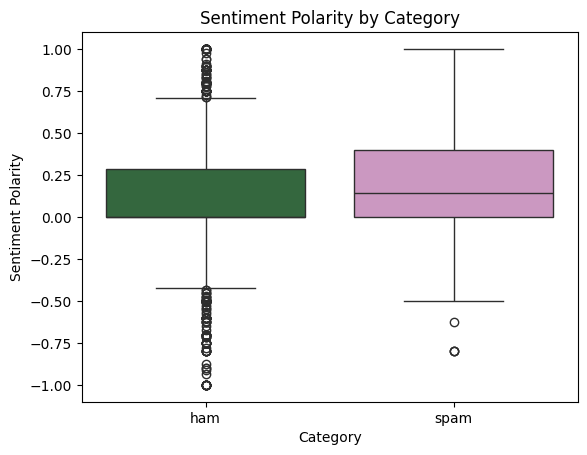

In [ ]:
from textblob import TextBlob
df['sentiment_polarity'] = df['Message'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.boxplot(x='Category', y='sentiment_polarity', data=df, palette="cubehelix")
plt.title("Sentiment Polarity by Category")
plt.xlabel("Category")
plt.ylabel("Sentiment Polarity")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame and it has 'Category' and 'Message' columns.
# Create a CountVectorizer with bigrams and stopwords
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Extract bigrams for spam messages
spam_bigrams = vectorizer.fit_transform(df[df['Category'] == 'spam']['Message'])

# Create a DataFrame for bigram counts
bigram_counts = pd.DataFrame(
    spam_bigrams.sum(axis=0).T,
    index=vectorizer.get_feature_names_out(),
    columns=['count']
)

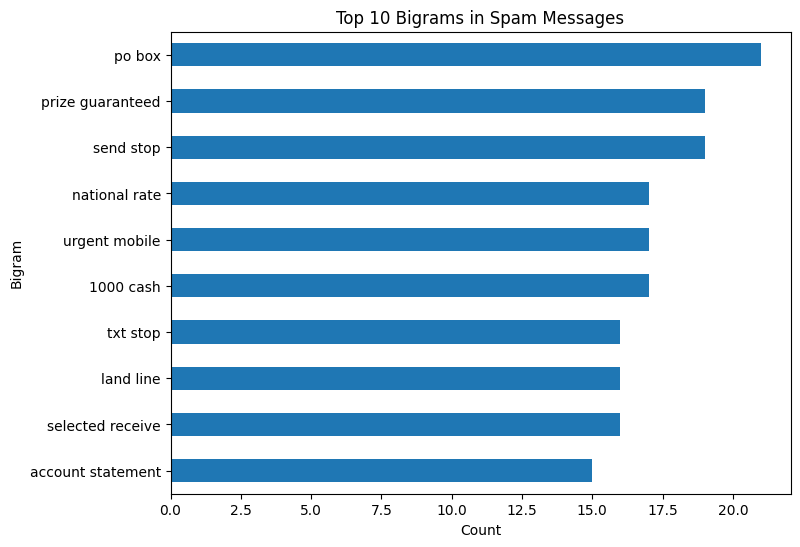

In [ ]:
# Sort and select the top 10 bigrams
top_bigrams = bigram_counts.sort_values(by='count', ascending=False).head(10)

# Plot top bigrams
top_bigrams.plot(kind='barh', figsize=(8, 6), legend=False)
plt.title("Top 10 Bigrams in Spam Messages")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.gca().invert_yaxis()  # To display the largest count at the top
plt.show()

In [ ]:
# remove tags
def remove_tag(text):
    pattren = re.compile('<[^>]+>')
    return pattren.sub(r'', text)
# remove URLs
def remove_urls(text):
    pattren = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattren.sub(r'', text)

import re
def remove_emojis(text):
    # Define a regex pattern to match emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    # Substitute emojis with an empty string
    return emoji_pattern.sub(r'', text)
# Define a dictionary of chat word mappings
chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)

# from textblob import TextBlob


# # Correct the spelling in each review
# df['review_corrected'] = df['review'].apply(lambda x: str(TextBlob(x).correct()))
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    new_text = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_text)

# remove punctuation from discription column;
puncuations = string.punctuation
exclude = puncuations
def remove_punc(text):
    for char in exclude:
        text = text.replace(char, '')
        return text


In [ ]:
import nltk

nltk.download('stopwords')
df['Message'] = df['Message'].str.lower()
df['Message'] = df['Message'].apply(remove_tag)
df['Message'] = df['Message'].apply(remove_urls)
df['Message'] = df['Message'].apply(remove_emojis)
df['Message'] = df['Message'].apply(chat_conversion)
df['Message'] = df['Message'].apply(remove_stopwords)
df['Message'] = df['Message'].apply(remove_punc)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Splitting data
X = df['Message']
y = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(2, 2))),  # Apply bigram (2-gram)
    ('Naive Bayes', MultinomialNB())
])

# Train the pipeline
pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.2f}")

Naive Bayes Accuracy: 0.98


In [ ]:
# prompt: generate a code to create model file using pickle

import pickle

# Assuming 'pipeline' is your trained model from the previous code.

# Save the model to a file
filename = 'spam_detection_model.pkl'
pickle.dump(pipeline, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to spam_detection_model.pkl


In [ ]:
# prompt: also create vectorizer

# The code provided already creates a CountVectorizer.
# It's used within the pipeline.  If you need to access it
# separately, you can do so after fitting the pipeline.

# Example usage:
vectorizer = pipeline.named_steps['vectorizer']

# Now you can use vectorizer to transform new text data:
# new_text = ['This is a new message', 'Another one to test']
# transformed_text = vectorizer.transform(new_text)

# Or if you want the vectorizer's vocabulary:
# vocabulary = vectorizer.vocabulary_

# The following code is already included in your provided code.
# I am including it here to demonstrate where the vectorizer is being created.
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(ngram_range=(2, 2))